In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import time

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url, sep=';')

data = data[data['total sulfur dioxide']<200]

cols_to_z_score = data.keys()
cols_to_z_score = cols_to_z_score.drop('residual sugar')

# for col in cols_to_z_score:
#     meanval = np.mean(data[col])
#     stdev = np.std(data[col], ddof=0)
#     data[col] = (data[col]-meanval) / stdev
data[cols_to_z_score] = data[cols_to_z_score].apply(stats.zscore)  

In [3]:
data_values = data[cols_to_z_score].values
labels = data['residual sugar'].values

In [4]:
random_indexes = torch.randint(len(labels), (10,))

test_labels = labels[random_indexes]
test_data = data_values[random_indexes, :]

train_labels = np.delete(labels, random_indexes)
train_data = np.delete(data_values, random_indexes, 0)

print(train_data.shape)
print(train_labels.shape)
print(' ')
print(test_data.shape)
print(test_labels.shape)


(1587, 11)
(1587,)
 
(10, 11)
(10,)


In [5]:
train_dataT = torch.tensor(train_data).float()
train_labelsT = torch.tensor(train_labels).float()
test_dataT = torch.tensor(test_data).float()
test_labelsT = torch.tensor(test_labels).float()

train_labelsT = train_labelsT[:, None]
test_labelsT = test_labelsT[:, None]

In [30]:
train_dataset = TensorDataset(train_dataT, train_labelsT)
test_dataset = TensorDataset(test_dataT, test_labelsT)

batch_size=16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [31]:
def create_model():
    VINEiris = nn.Sequential(
    nn.Linear(11, 16),
    nn.ReLU(),
    nn.BatchNorm1d(16),
    nn.Linear(16, 32),
    nn.ReLU(),
    nn.BatchNorm1d(32),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.BatchNorm1d(32),
    nn.Linear(32, 1),
    )
    
    loss_fun = nn.MSELoss()
    optimizer = torch.optim.Adam(VINEiris.parameters(), lr=.001)
    
    return VINEiris, loss_fun, optimizer

In [32]:
num_of_epochs = 500

def train_model(model, loss_func, optimizer):
    train_losses = []
    test_losses = []
    
    for epoch in range(num_of_epochs):
        model.train()
        batch_train_loss = []
        for X, y in train_loader:
            yHat = model(X)
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_train_loss.append(loss.item())
            
        train_losses.append(np.mean(batch_train_loss))
        
        model.eval()
        X,y = next(iter(test_loader))
        yHat = model(X)
        test_losses.append((yHat-y).pow(2).mean().item())
    
    return train_losses, test_losses

In [33]:
model, loss_func, optimizer = create_model()

train_losses, test_losses = train_model(model, loss_func, optimizer)

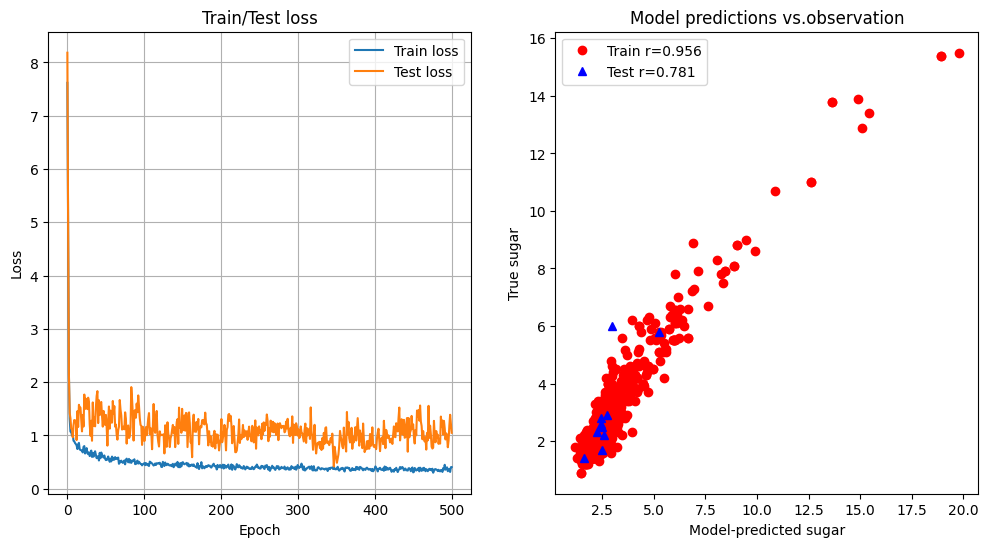

In [34]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].plot(train_losses, label='Train loss')
ax[0].plot(test_losses, label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()

y_hat_train = model(train_dataT)
y_hat_test = model(test_dataT)
ax[1].plot(y_hat_train.detach(), train_labelsT, 'ro')
ax[1].plot(y_hat_test.detach(), test_labelsT, 'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs.observation')

corr_train = np.corrcoef(y_hat_train.detach().T, train_labels.T)[1,0]
corr_test = np.corrcoef(y_hat_test.detach().T, test_labels.T)[1,0]
ax[1].legend([f"Train r={corr_train:.3f}", f"Test r={corr_test:.3f}"])

plt.show()